<a href="https://colab.research.google.com/github/YaeliBarGimelshtein/ML-NN/blob/main/HW3_NEURON_NETWORKS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Home Work 3: Digit identification with MNIST

In [ ]:
# imports
import torch
from torch import nn
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
from prettytable import PrettyTable
import sklearn
from sklearn import metrics
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# normalzing functuion for the values in the to be from zero to one
image_normalize = lambda x : x / 255.

In [ ]:
#loading the train and validation from MNIST
train_val_loader = torch.utils.data.DataLoader(datasets.MNIST('/files/', 
                                                          train=True, 
                                                          download=True, 
                                                          transform=transforms.Compose([transforms.ToTensor(), transforms.Lambda(image_normalize)])),                                                         
                                                          batch_size=50, 
                                                          shuffle=True)
train_set, val_set = torch.utils.data.random_split(train_val_loader.dataset, [50000, 10000])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=50, shuffle=False)
valid_loader = torch.utils.data.DataLoader(val_set, batch_size=50,  shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



In [ ]:
#loading the train and validation from MNIST for batch = 100
train_loader_5_b = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=False)
valid_loader_5_b = torch.utils.data.DataLoader(val_set, batch_size=100, shuffle=False)

In [ ]:
#loading the test from MNIST
test_loader = torch.utils.data.DataLoader(datasets.MNIST('/files/', 
                                                          train=False, 
                                                          download=True, 
                                                          transform=transforms.Compose([transforms.ToTensor(), transforms.Lambda(image_normalize)])),                                                         
                                                          batch_size=50, 
                                                          shuffle=True)

In [ ]:
#saving the data to later plot it
train_data_all = train_val_loader.dataset.data.index_select(0,torch.IntTensor(train_set.indices)) /255
train_labels_all = train_val_loader.dataset.targets.index_select(0,torch.IntTensor(train_set.indices))

valid_data_all = train_val_loader.dataset.data.index_select(0,torch.IntTensor(val_set.indices)) / 255
valid_labels_all = train_val_loader.dataset.targets.index_select(0,torch.IntTensor(val_set.indices))

test_data_all = test_loader.dataset.data / 255
test_labels_all = test_loader.dataset.targets

In [ ]:
## setting the loss function & loop counter & learning rate
loss = torch.nn.CrossEntropyLoss()
lr = 0.01
lr_conv = 1e-3
loss = loss.to(device)


In [ ]:
# from StackOverflow https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model

def count_weights(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params


In [ ]:
#traning the model on train set

def train_the_model(model, learn_rate):
  optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
  start = time.time()
  counter = 0
  while counter < 13000 :
    for (train_data, train_labels) in train_loader:
      train_data, train_labels = train_data.to(device), train_labels.to(device)
      cross_entropy = loss(model(train_data), train_labels)
      # zero gradients berfore running the backward pass
      optimizer.zero_grad()
      # backward pass to compute the gradient of loss, backprop + accumulate 
      cross_entropy.backward()
      # update params
      optimizer.step()
      counter += 1
  end = time.time()
  print("Final train CE loss: ", loss(model(train_data), train_labels).item())
  return end - start


In [ ]:
#traning the model on train set for batch = 100

def train_the_model_b(model, learn_rate):
  optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
  start = time.time()
  counter = 0
  while counter < 13000 :
    for (train_data, train_labels) in train_loader_5_b:
      train_data, train_labels = train_data.to(device), train_labels.to(device)
      cross_entropy = loss(model(train_data), train_labels)
      # zero gradients berfore running the backward pass
      optimizer.zero_grad()
      # backward pass to compute the gradient of loss, backprop + accumulate 
      cross_entropy.backward()
      # update params
      optimizer.step()
      counter += 1
  end = time.time()
  print("Final train CE loss: ", loss(model(train_data), train_labels).item())
  return end - start

In [ ]:
# predict which category is best for all test images (activate foward function)

def predict(trained_model , x):
  x = x.to(device)
  return trained_model(x)

In [ ]:
#calcs score = Accuracy, F score, Precision, Recall from https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

def score(y, t):
  y_one_predict = torch.argmax(y,1).cpu() #softmax
  names = ['number 0', 'number 1', 'number 2', 'number 3','number 4','number 5','number 6','number 7','number 8','number 9']
  return metrics.classification_report(t, y_one_predict, target_names=names)

In [ ]:
#calcs score = Accuracy, F score, Precision, Recall from https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
def conv_score(y,t):
  names = ['number 0', 'number 1', 'number 2', 'number 3','number 4','number 5','number 6','number 7','number 8','number 9']
  return metrics.classification_report(t, y, target_names=names)
  return params

In [ ]:
#for printing the conv image
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [ ]:
def conv_image(model, layer, index, dataset, key):
  model.cpu()
  model[layer].register_forward_hook(get_activation(key))
  output = model(dataset[0].reshape(1,1,28,28))
  filters = activation[key][0][0]
  plt.imshow(filters.cpu(), cmap='gray')
  #show the figure
  plt.show()

In [ ]:
def weight_image(model,layer,channel):
  weights = model[layer].weight.data
  print("This is the weights in layer ", layer, "at channel ", channel)
  filters = weights[channel][0]
  #normalize filter values to 0-1 so we can visualize them
  f_min, f_max = filters.min(), filters.max()
  filters = (filters - f_min) / (f_max - f_min)
  #plot first few filters
  plt.imshow(filters.cpu(), cmap='gray')
  #show the figure
  plt.show()

In [ ]:
def origin_image(dataset, index, dataset_labels):
  plt.figure()
  imgplot = plt.imshow(dataset[index])
  plt.title("lable: " + str(dataset_labels.float()[index])[-3:-2] )
  #show the figure
  plt.show()

## The first architecture: Logistic regression ⚛

In [ ]:
model_q1 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 10)
)

model_q1 = model_q1.to(device)

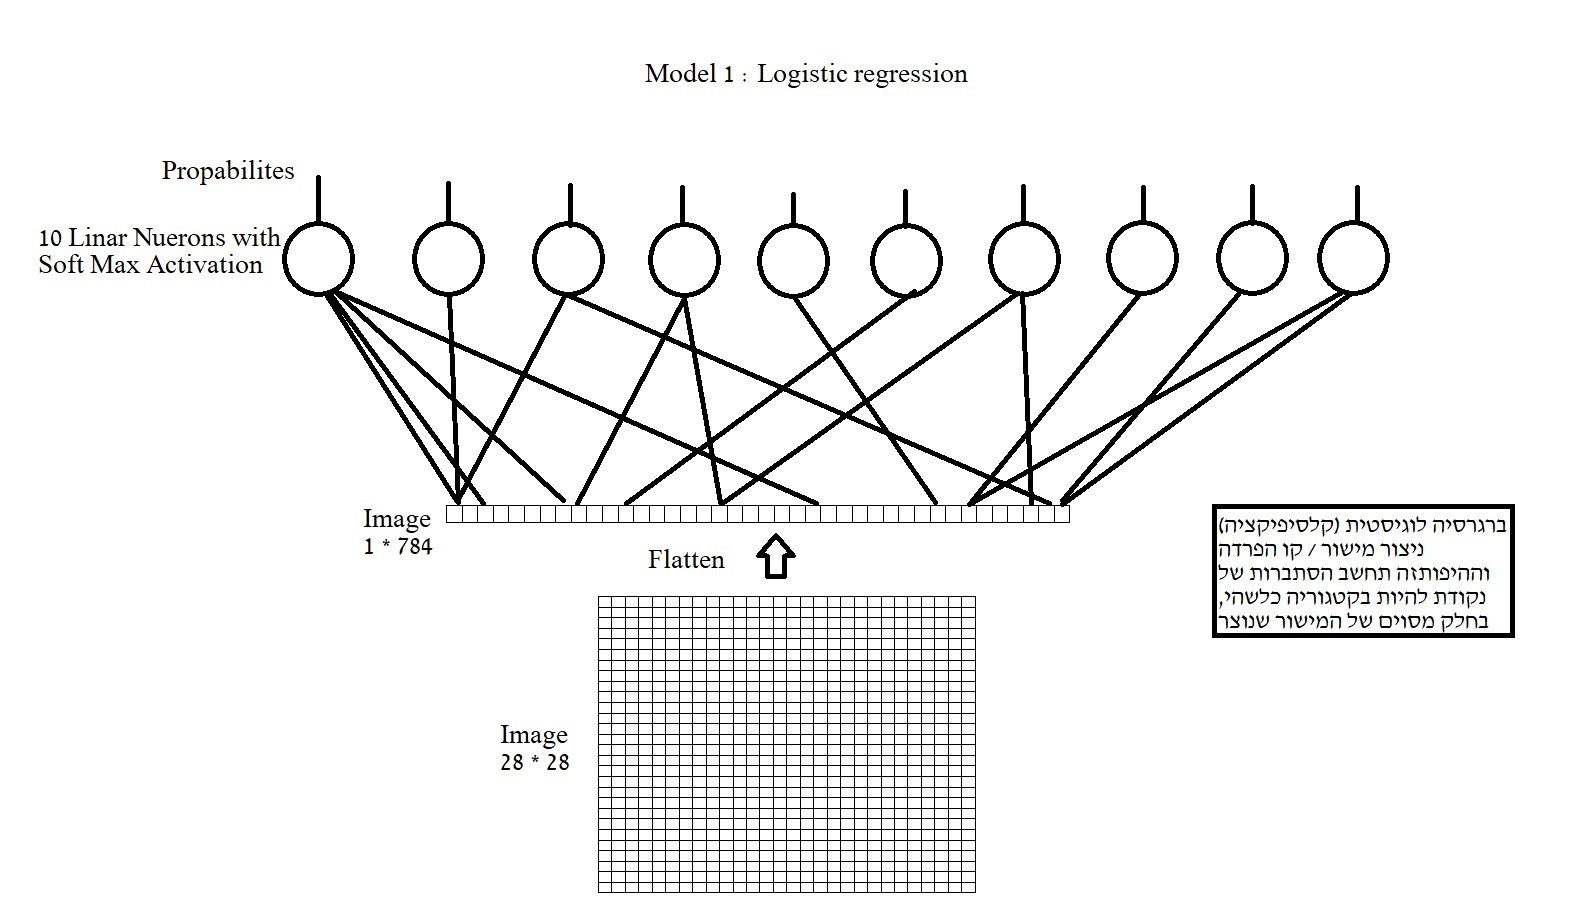

In [ ]:
# ANSWERING THE QUESTION
train_time = train_the_model(model_q1, lr) #train the model
print("train time for model 1 is ", train_time) #print the times trained
count_weights(model_q1) #print weights

print()
print("For train:")
y_train1 = predict(model_q1, train_data_all)
y_train1.cpu()
scores_train1 = score(y_train1, train_labels_all)
print(scores_train1) #print scores

print()
print("For validation:")
y_valid1 = predict(model_q1, valid_data_all)
y_valid1.cpu()
scores_valid1 = score(y_valid1, valid_labels_all)
print(scores_valid1) #print scores

print()
print("For test:")
y_test1 = predict(model_q1, test_data_all)
y_test1.cpu()
scores_test1 = score(y_test1 , test_labels_all)
print(scores_test1) #print scores

Final train CE loss:  0.29426461458206177
train time for model 1 is  108.19557690620422
+----------+------------+
| Modules  | Parameters |
+----------+------------+
| 1.weight |    7840    |
|  1.bias  |     10     |
+----------+------------+
Total Trainable Params: 7850

For train:
              precision    recall  f1-score   support

    number 0       0.89      0.97      0.93      4873
    number 1       1.00      0.54      0.70      5625
    number 2       0.91      0.81      0.86      4928
    number 3       0.84      0.85      0.85      5123
    number 4       0.96      0.77      0.86      4885
    number 5       0.98      0.28      0.43      4517
    number 6       0.94      0.92      0.93      4916
    number 7       0.99      0.76      0.86      5222
    number 8       0.37      0.97      0.54      4910
    number 9       0.80      0.84      0.82      5001

    accuracy                           0.77     50000
   macro avg       0.87      0.77      0.78     50000
weighted av

## The second architecture: Logistic regression with 2 hidden layers ⚛

In [ ]:
model_q2 = nn.Sequential(
    nn.Flatten(), #input
    nn.Linear(784, 200), #layer 1
    nn.ReLU(),
    nn.Linear(200, 200), #layer 2
    nn.ReLU(),
    nn.Linear(200, 10) #output
)
model_q2 = model_q2.to(device)

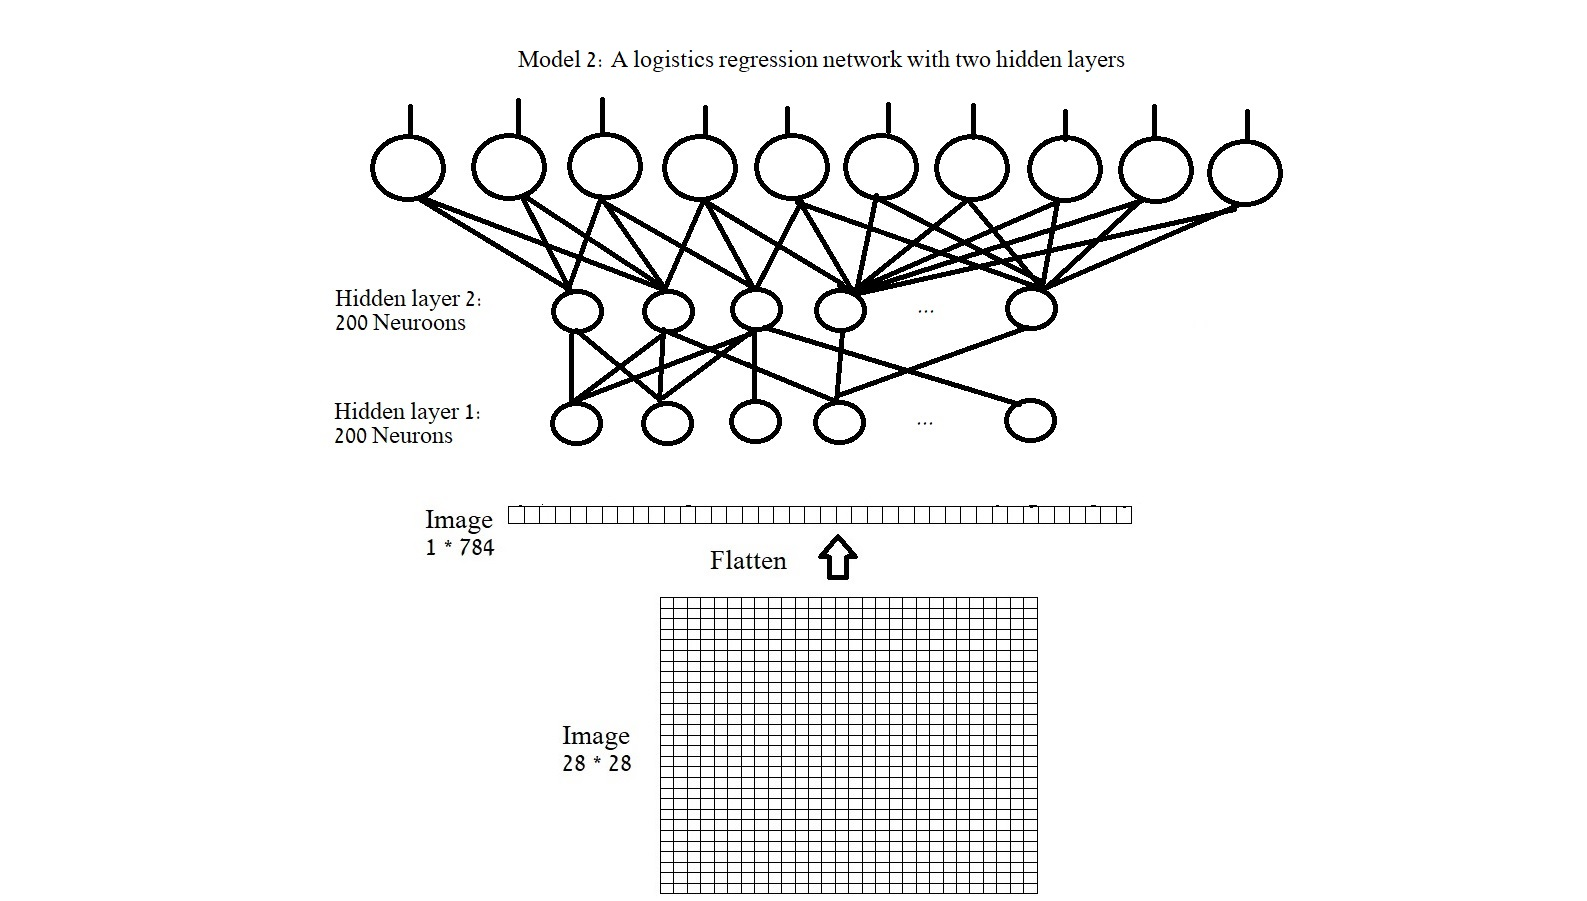

In [ ]:
# ANSWERING THE QUESTION
train_time2 = train_the_model(model_q2, lr) #train the model
print("train time for model 2 is ", train_time2) #print the times trained
count_weights(model_q2) #print weights

print()
print("For train:")
y_train2 = predict(model_q2, train_data_all)
y_train2 = y_train2.cpu()
scores_train2 = score(y_train2, train_labels_all)
print(scores_train2) #print scores

print()
print("For validation:")
y_valid2 = predict(model_q2, valid_data_all)
y_valid2 = y_valid2.cpu()
scores_valid2 = score(y_valid2, valid_labels_all)
print(scores_valid2) #print scores

print()
print("For test:")
y_test2 = predict(model_q2, test_data_all)
y_test2 = y_test2.cpu()
scores_test2 = score(y_test2 , test_labels_all)
print(scores_test2) #print scores

Final train CE loss:  0.006696898490190506
train time for model 2 is  118.04930758476257
+----------+------------+
| Modules  | Parameters |
+----------+------------+
| 1.weight |   156800   |
|  1.bias  |    200     |
| 3.weight |   40000    |
|  3.bias  |    200     |
| 5.weight |    2000    |
|  5.bias  |     10     |
+----------+------------+
Total Trainable Params: 199210

For train:
              precision    recall  f1-score   support

    number 0       0.90      1.00      0.94      4873
    number 1       0.93      0.99      0.96      5625
    number 2       0.64      0.98      0.78      4928
    number 3       0.90      0.97      0.93      5123
    number 4       1.00      0.68      0.81      4885
    number 5       0.92      0.97      0.94      4517
    number 6       0.99      0.93      0.96      4916
    number 7       0.63      0.97      0.77      5222
    number 8       0.95      0.45      0.61      4910
    number 9       0.93      0.45      0.61      5001

    accuracy

### For this models, a new function will help me to set the weights

In [ ]:
def init_conv2d_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight)
        m.weight = nn.Parameter(torch.abs(m.weight))
        m.bias.data.fill_(0.01)

##The third architecture: Convolution network with convolution layer, max pool and FC ⚛

In [ ]:
model_q3 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5,5), stride=(1,1), padding='same'), # conv layer
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)), # pool layer
    nn.Flatten(),
    nn.Linear(in_features=32*14*14, out_features=1024), #fully connected
    nn.ReLU(),
    nn.Linear(in_features=1024, out_features=10) #soft max output
)

model_q3.apply(init_conv2d_weights)
model_q3 = model_q3.to(device)

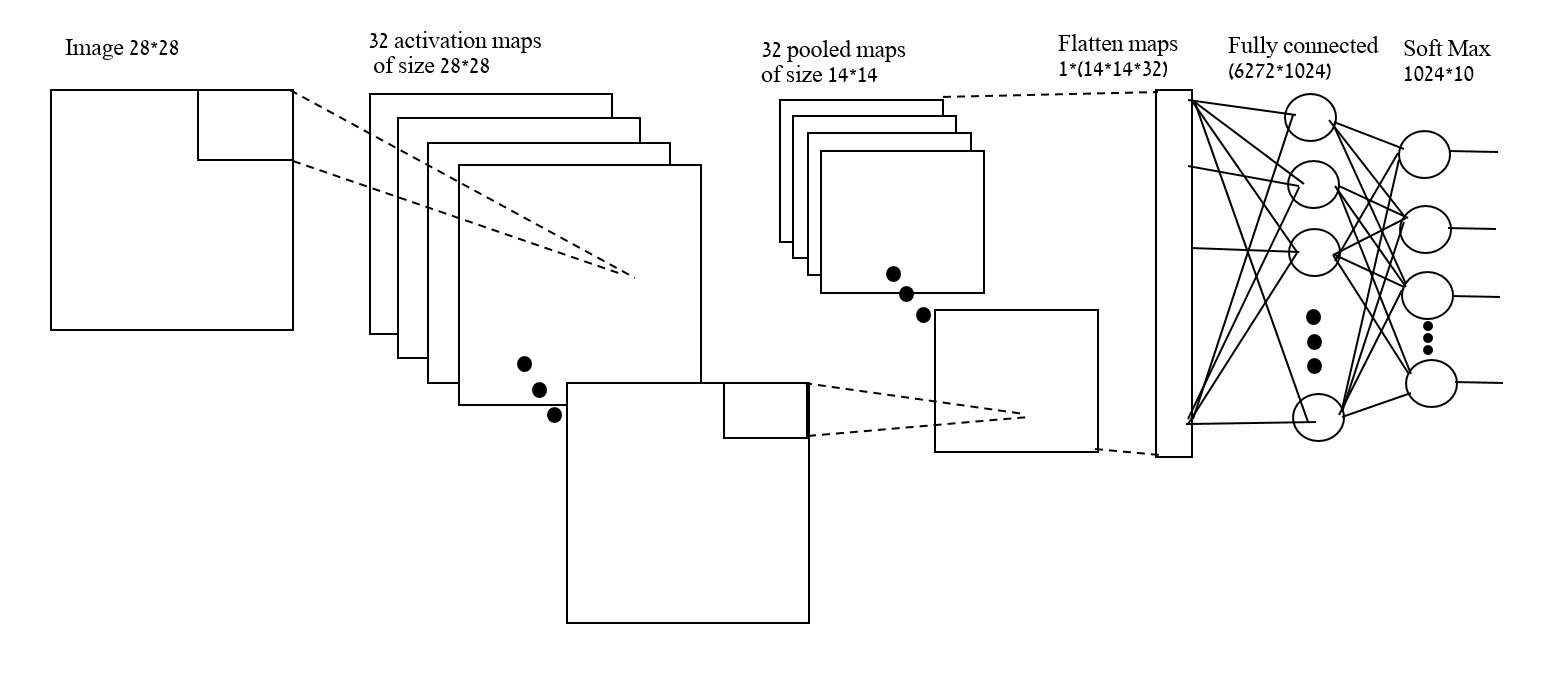

In [ ]:
summary(model_q3, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
           Flatten-4                 [-1, 6272]               0
            Linear-5                 [-1, 1024]       6,423,552
              ReLU-6                 [-1, 1024]               0
            Linear-7                   [-1, 10]          10,250
Total params: 6,434,634
Trainable params: 6,434,634
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.49
Params size (MB): 24.55
Estimated Total Size (MB): 25.04
----------------------------------------------------------------


Reshaping the data since there is no batch dimension

In [ ]:
# ANSWERING THE QUESTION
train_time3 = train_the_model(model_q3, lr_conv) #train the model
print("train time for model 3 is ", train_time3) #print the times trained
count_weights(model_q3) #print weights

print()
print("For train:")
y_train3 = []
for i in range(train_data_all.size()[0]):
  max, index= torch.max(predict(model_q3, train_data_all[i].reshape(1,1,28,28)),1)
  y_train3.append(index.cpu().numpy().item())
y_train3= np.array(y_train3)
scores_train3 = conv_score(y_train3, train_labels_all.cpu().numpy())
print(scores_train3)


print()
print("For validation:")
y_valid3 = []
for i in range(valid_data_all.size()[0]):
  max, index= torch.max(predict(model_q3, valid_data_all[i].reshape(1,1,28,28)),1)
  y_valid3.append(index.cpu().numpy().item())

scores_valid3 = conv_score(y_valid3, valid_labels_all.cpu().numpy())
print(scores_valid3)

print()
print("For test:")
y_test3 = []
for i in range(test_data_all.size()[0]):
  max, index= torch.max(predict(model_q3, test_data_all[i].reshape(1,1,28,28)),1)
  y_test3.append(index.cpu().numpy().item())

scores_test3 = conv_score(y_test3, test_labels_all.cpu().numpy())
print(scores_test3)

Final train CE loss:  0.048125363886356354
train time for model 3 is  121.98288631439209
+----------+------------+
| Modules  | Parameters |
+----------+------------+
| 0.weight |    800     |
|  0.bias  |     32     |
| 4.weight |  6422528   |
|  4.bias  |    1024    |
| 6.weight |   10240    |
|  6.bias  |     10     |
+----------+------------+
Total Trainable Params: 6434634

For train:
              precision    recall  f1-score   support

    number 0       0.97      1.00      0.99      4873
    number 1       0.98      1.00      0.99      5625
    number 2       0.99      0.98      0.98      4928
    number 3       0.98      0.98      0.98      5123
    number 4       1.00      0.97      0.98      4885
    number 5       0.99      0.98      0.98      4517
    number 6       0.99      0.99      0.99      4916
    number 7       0.96      1.00      0.98      5222
    number 8       0.99      0.96      0.98      4910
    number 9       0.98      0.96      0.97      5001

    accurac

`balanced accuracy` is 0.97, I will show all pics even that the question said to the highest

This is the weights in layer  0 at channel  0


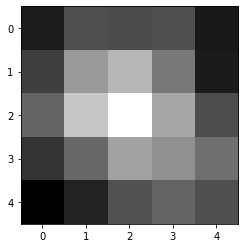

This is the weights in layer  0 at channel  1


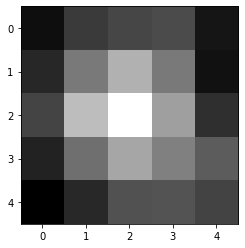

This is the weights in layer  0 at channel  2


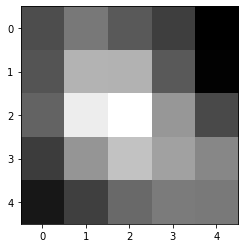

This is the weights in layer  0 at channel  3


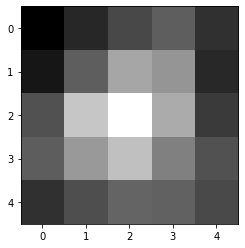

This is the weights in layer  0 at channel  4


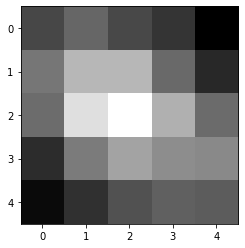

In [ ]:
#print weights
for i in range(5):
  weight_image(model_q3, 0, i)

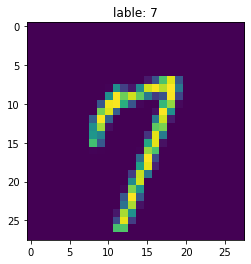

In [ ]:
#printing the origin images
origin_image(train_data_all, 0, train_labels_all)

layer 0 before Relu


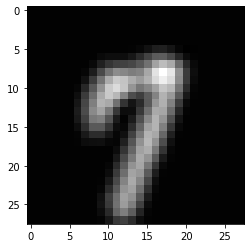

layer 0 after Relu


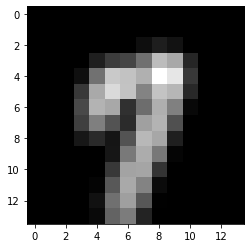

In [ ]:
#print conv images
print("layer 0 before Relu")
conv_image(model_q3, 0, 0, train_data_all, "model_q3[0]before")
print("layer 0 after Relu")
conv_image(model_q3, 2, 0, train_data_all, "model_q3[0]after")




##The fourth architecture: Convolution network with 2 convolution layers, 2 max pools and FC ⚛

In [ ]:
model_q4 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5,5), stride=(1,1), padding='same'), #first conv layer
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)), #first pool layer
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), stride=(1,1), padding='same'), #second conv layer
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)), #second pool layer
    nn.Flatten(),
    nn.Linear(in_features=64*7*7, out_features=1024), #fully connected
    nn.ReLU(),
    nn.Linear(in_features=1024, out_features=10) #soft max output
)

model_q4.apply(init_conv2d_weights)
model_q4 = model_q4.to(device)

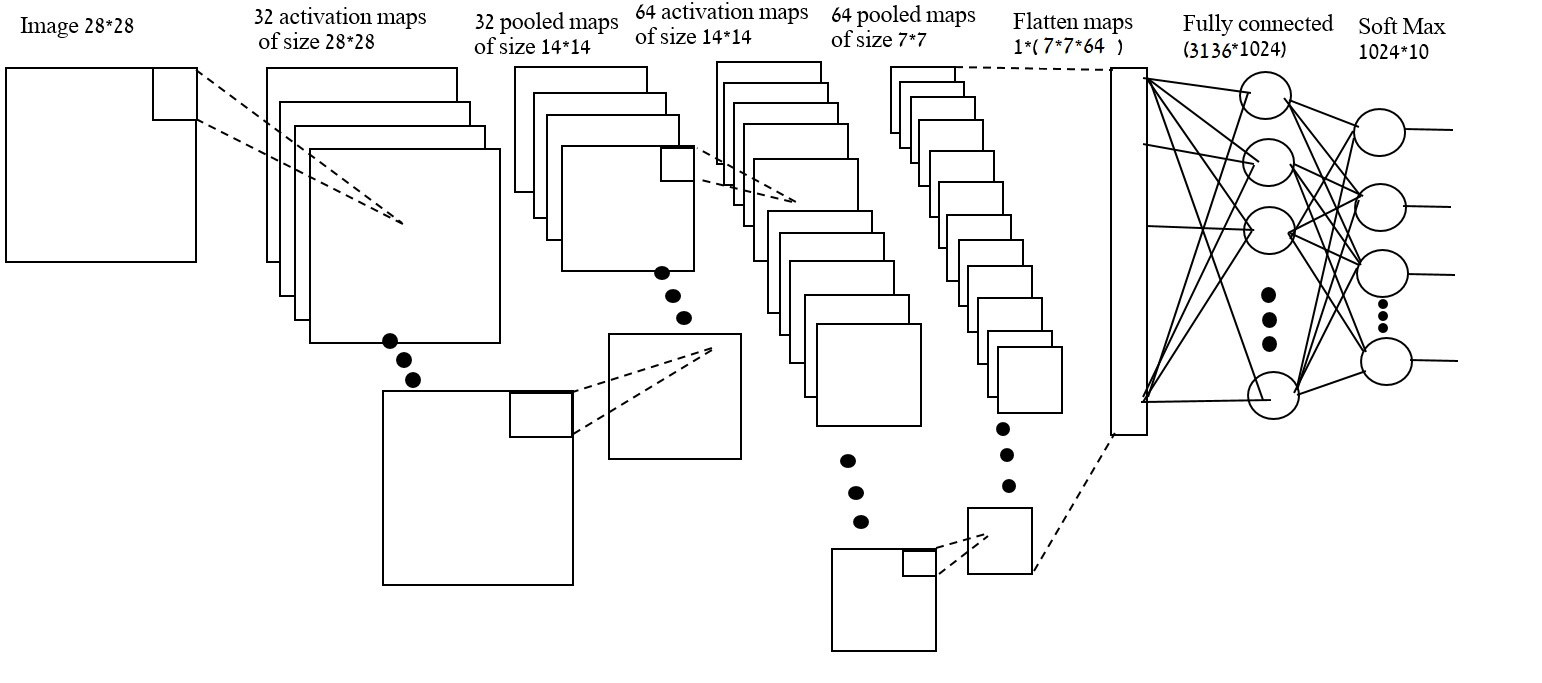

In [ ]:
summary(model_q4, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          51,264
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
           Flatten-7                 [-1, 3136]               0
            Linear-8                 [-1, 1024]       3,212,288
              ReLU-9                 [-1, 1024]               0
           Linear-10                   [-1, 10]          10,250
Total params: 3,274,634
Trainable params: 3,274,634
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.69
Params size (MB): 12.49
Estima

In [ ]:
# ANSWERING THE QUESTION
train_time4 = train_the_model(model_q4, lr_conv) #train the model
print("train time for model 4 is ", train_time4) #print the times trained
count_weights(model_q4) #print weights

print()
print("For train:")
y_train4 = []
for i in range(train_data_all.size()[0]):
  max, index= torch.max(predict(model_q4, train_data_all[i].reshape(1,1,28,28)),1)
  y_train4.append(index.cpu().numpy().item())
y_train4= np.array(y_train4)
scores_train4 = conv_score(y_train4, train_labels_all.cpu().numpy())
print(scores_train4)


print()
print("For validation:")
y_valid4 = []
for i in range(valid_data_all.size()[0]):
  max, index= torch.max(predict(model_q4, valid_data_all[i].reshape(1,1,28,28)),1)
  y_valid4.append(index.cpu().numpy().item())

scores_valid4 = conv_score(y_valid4, valid_labels_all.cpu().numpy())
print(scores_valid4)

print()
print("For test:")
y_test4 = []
for i in range(test_data_all.size()[0]):
  max, index= torch.max(predict(model_q4, test_data_all[i].reshape(1,1,28,28)),1)
  y_test4.append(index.cpu().numpy().item())

scores_test4 = conv_score(y_test4, test_labels_all.cpu().numpy())
print(scores_test4)

Final train CE loss:  0.03397969529032707
train time for model 4 is  132.06647753715515
+----------+------------+
| Modules  | Parameters |
+----------+------------+
| 0.weight |    800     |
|  0.bias  |     32     |
| 3.weight |   51200    |
|  3.bias  |     64     |
| 7.weight |  3211264   |
|  7.bias  |    1024    |
| 9.weight |   10240    |
|  9.bias  |     10     |
+----------+------------+
Total Trainable Params: 3274634

For train:
              precision    recall  f1-score   support

    number 0       0.99      1.00      1.00      4873
    number 1       1.00      0.99      1.00      5625
    number 2       0.99      0.99      0.99      4928
    number 3       0.99      0.99      0.99      5123
    number 4       0.99      1.00      0.99      4885
    number 5       1.00      0.98      0.99      4517
    number 6       1.00      1.00      1.00      4916
    number 7       0.97      1.00      0.98      5222
    number 8       0.98      1.00      0.99      4910
    number 9   

`balanced accuracy` is 0.99, I will show all pics even that the question said to the highest

This is the weights in layer  0 at channel  0


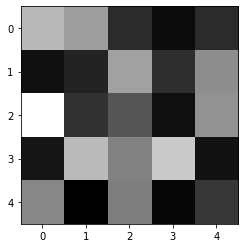

This is the weights in layer  0 at channel  1


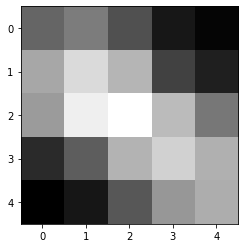

This is the weights in layer  0 at channel  2


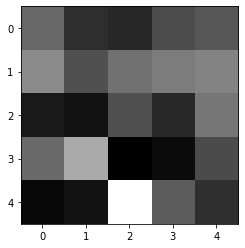

This is the weights in layer  0 at channel  3


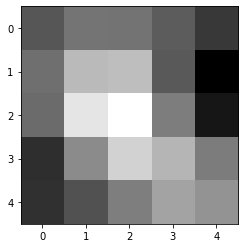

This is the weights in layer  0 at channel  4


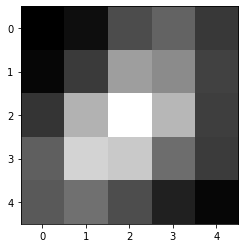

In [ ]:
#print weights
for i in range(5):
  weight_image(model_q4, 0, i)

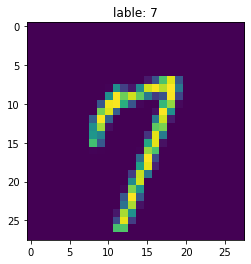

In [ ]:
#printing the origin images
origin_image(train_data_all, 0, train_labels_all)

layer 0 before Relu


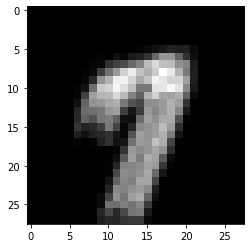

layer 0 after Relu


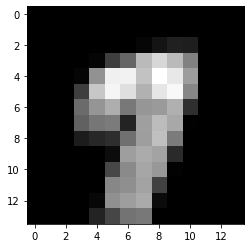

layer 1 before Relu


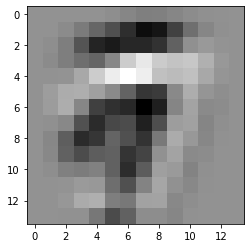

layer 1 after Relu


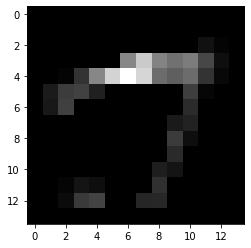

In [ ]:
#print conv images
print("layer 0 before Relu")
conv_image(model_q4, 0, 0, train_data_all, "model_q4[0]before")
print("layer 0 after Relu")
conv_image(model_q4, 2, 0, train_data_all, "model_q4[0]after")
print("layer 1 before Relu")
conv_image(model_q4, 3, 0, train_data_all, "model_q4[1]before")
print("layer 1 after Relu")
conv_image(model_q4, 4, 0, train_data_all, "model_q4[1]after")

##The fifth architecture: Convolution network with 2 convolution layers, 2 max pools and FC with dropout  ⚛

In [ ]:
model_q5 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5,5), stride=(1,1), padding='same'), #first conv layer
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)), #first pool layer
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), stride=(1,1), padding='same'), #second conv layer
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)), #second pool layer
    nn.Flatten(),
    nn.Dropout(p=0.5), #dropout for the fully connected layer
    nn.Linear(in_features=64*7*7, out_features=1024), #fully connected
    nn.ReLU(),
    nn.Linear(in_features=1024, out_features=10) #soft max output
)

model_q5.apply(init_conv2d_weights)
model_q5 = model_q5.to(device)

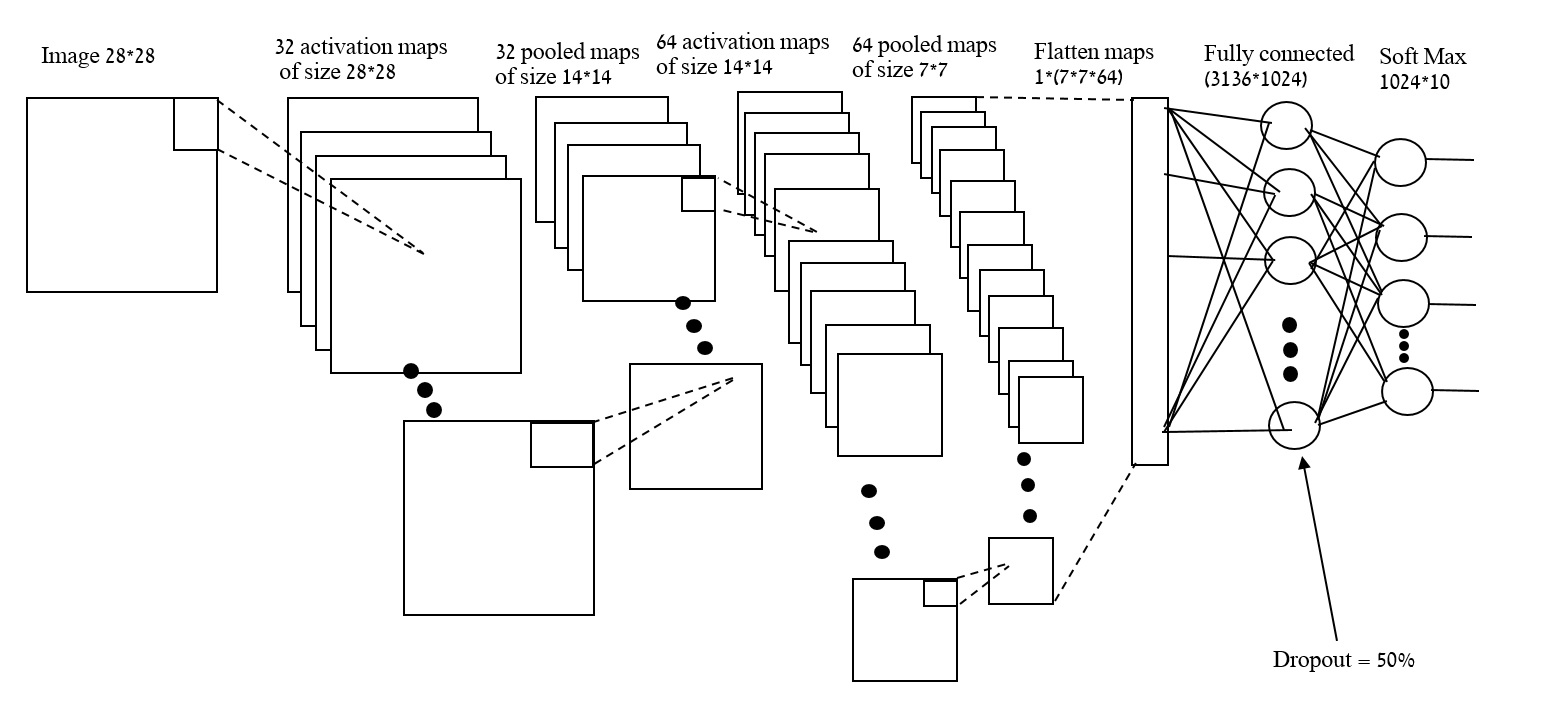

In [ ]:
summary(model_q5, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          51,264
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
           Flatten-7                 [-1, 3136]               0
           Dropout-8                 [-1, 3136]               0
            Linear-9                 [-1, 1024]       3,212,288
             ReLU-10                 [-1, 1024]               0
           Linear-11                   [-1, 10]          10,250
Total params: 3,274,634
Trainable params: 3,274,634
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

In [ ]:
# ANSWERING THE QUESTION
train_time5 = train_the_model(model_q5, lr_conv) #train the model
print("train time for model 5 is ", train_time5) #print the times trained
count_weights(model_q5) #print weights

print()
print("For train:")
y_train5 = []
for i in range(train_data_all.size()[0]):
  max, index= torch.max(predict(model_q5, train_data_all[i].reshape(1,1,28,28)),1)
  y_train5.append(index.cpu().numpy().item())
y_train5= np.array(y_train5)
scores_train5 = conv_score(y_train5, train_labels_all.cpu().numpy())
print(scores_train5)


print()
print("For validation:")
y_valid5 = []
for i in range(valid_data_all.size()[0]):
  max, index= torch.max(predict(model_q5, valid_data_all[i].reshape(1,1,28,28)),1)
  y_valid5.append(index.cpu().numpy().item())

scores_valid5 = conv_score(y_valid5, valid_labels_all.cpu().numpy())
print(scores_valid5)

print()
print("For test:")
y_test5 = []
for i in range(test_data_all.size()[0]):
  max, index= torch.max(predict(model_q5, test_data_all[i].reshape(1,1,28,28)),1)
  y_test5.append(index.cpu().numpy().item())

scores_test5 = conv_score(y_test5, test_labels_all.cpu().numpy())
print(scores_test5)

Final train CE loss:  0.004972195252776146
train time for model 5 is  144.09911608695984
+-----------+------------+
|  Modules  | Parameters |
+-----------+------------+
|  0.weight |    800     |
|   0.bias  |     32     |
|  3.weight |   51200    |
|   3.bias  |     64     |
|  8.weight |  3211264   |
|   8.bias  |    1024    |
| 10.weight |   10240    |
|  10.bias  |     10     |
+-----------+------------+
Total Trainable Params: 3274634

For train:
              precision    recall  f1-score   support

    number 0       0.99      1.00      0.99      4898
    number 1       0.98      0.99      0.99      5683
    number 2       1.00      0.97      0.98      5036
    number 3       0.98      0.99      0.99      5070
    number 4       0.94      1.00      0.97      4821
    number 5       0.99      0.98      0.99      4544
    number 6       0.99      1.00      0.99      4911
    number 7       0.97      0.99      0.98      5263
    number 8       0.99      0.96      0.98      4826
  

`balanced accuracy` is 0.99, I will show all pics even that the question said to the highest

In [ ]:
#now doing the same for batch = 100
train_time5_b = train_the_model_b(model_q5, lr_conv) #train the model
print("train time for model 5b is ", train_time5_b) #print the times trained
count_weights(model_q5) #print weights

print()
print("For train:")
y_train5_b = []
for i in range(train_data_all.size()[0]):
  max_b, index_b= torch.max(predict(model_q5, train_data_all[i].reshape(1,1,28,28)),1)
  y_train5_b.append(index_b.cpu().numpy().item())
y_train5_b= np.array(y_train5_b)
scores_train5_b = conv_score(y_train5_b, train_labels_all.cpu().numpy())
print(scores_train5_b)


print()
print("For validation:")
y_valid5_b = []
for i in range(valid_data_all.size()[0]):
  max_b, index_b= torch.max(predict(model_q5, valid_data_all[i].reshape(1,1,28,28)),1)
  y_valid5_b.append(index_b.cpu().numpy().item())

scores_valid5_b = conv_score(y_valid5_b, valid_labels_all.cpu().numpy())
print(scores_valid5_b)

print()
print("For test:")
y_test5_b = []
for i in range(test_data_all.size()[0]):
  max_b, index_b= torch.max(predict(model_q5, test_data_all[i].reshape(1,1,28,28)),1)
  y_test5_b.append(index_b.cpu().numpy().item())

scores_test5_b = conv_score(y_test5_b, test_labels_all.cpu().numpy())
print(scores_test5_b)

Final train CE loss:  0.010157311335206032
train time for model 5b is  247.35878229141235
+-----------+------------+
|  Modules  | Parameters |
+-----------+------------+
|  0.weight |    800     |
|   0.bias  |     32     |
|  3.weight |   51200    |
|   3.bias  |     64     |
|  8.weight |  3211264   |
|   8.bias  |    1024    |
| 10.weight |   10240    |
|  10.bias  |     10     |
+-----------+------------+
Total Trainable Params: 3274634

For train:
              precision    recall  f1-score   support

    number 0       0.99      1.00      1.00      4931
    number 1       0.99      1.00      0.99      5602
    number 2       0.99      1.00      0.99      4975
    number 3       0.99      0.98      0.99      5104
    number 4       0.95      1.00      0.98      4872
    number 5       1.00      0.98      0.99      4535
    number 6       0.99      0.99      0.99      4920
    number 7       0.97      1.00      0.98      5219
    number 8       0.99      0.98      0.98      4840
 

as we can see, the loss on `batch=50`is smaller

This is the weights in layer  0 at channel  0


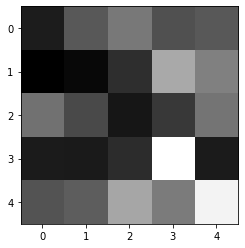

This is the weights in layer  0 at channel  1


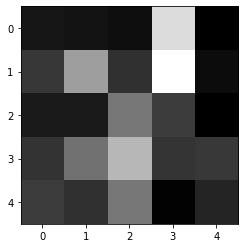

This is the weights in layer  0 at channel  2


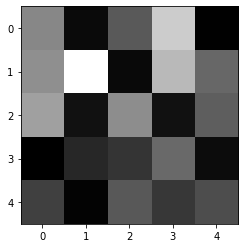

This is the weights in layer  0 at channel  3


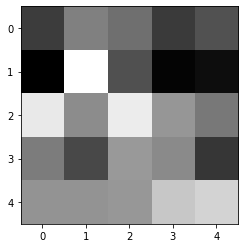

This is the weights in layer  0 at channel  4


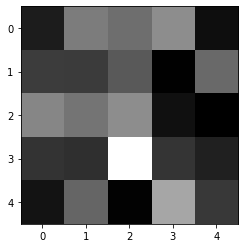

In [ ]:
#print weights
for i in range(5):
  weight_image(model_q5, 0, i)

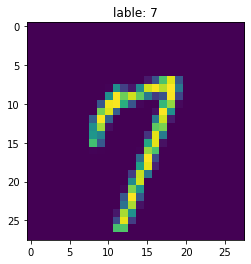

In [ ]:
#printing the origin images
origin_image(train_data_all, 0, train_labels_all)

layer 0 before Relu


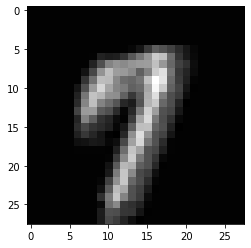

layer 0 after Relu


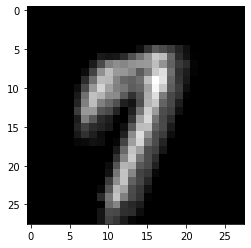

layer 1 before Relu


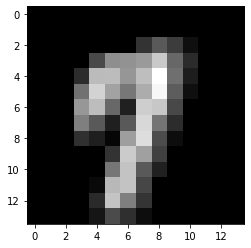

layer 1 after Relu


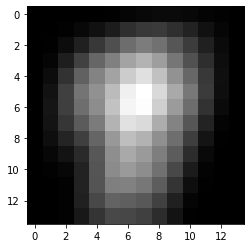

In [ ]:
#print conv images
print("layer 0 before Relu")
conv_image(model_q5, 0, 0, train_data_all, "model_q5[0]before")
print("layer 0 after Relu")
conv_image(model_q5, 1, 0, train_data_all, "model_q5[0]after")
print("layer 1 before Relu")
conv_image(model_q5, 2, 0, train_data_all, "model_q5[1]before")
print("layer 1 after Relu")
conv_image(model_q5, 3, 0, train_data_all, "model_q5[1]after")